In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as lines
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
def clona_figura(xstop):
    plt.hlines(0, 1, xstop,[(0.2, 0.4, 0.6, 0.6)], lw=7)
    plt.hlines(-1, 1, xstop,[(0.2, 0.4, 0.6, 0.6)], lw=7)
    plt.ylim(-2.15,2)
    

In [3]:
def monomeros(xstart, xstop, color='k'):
    ancho_linea_v = 1
    ancho_linea_h = 1
    y = 0.08
    plt.hlines(0, xstart, xstop, color, lw=ancho_linea_h,label='Monomeros')
    plt.vlines(xstart, y, -y, color, lw=ancho_linea_v)
    plt.vlines(xstop, y, -y, color, lw=ancho_linea_v)
    
    plt.hlines(-1, xstart, xstop, color, lw=ancho_linea_h,label='Monomeros')
    plt.vlines(xstart, y-1, -y-1, color, lw=ancho_linea_v)
    plt.vlines(xstop, y-1, -y-1, color, lw=ancho_linea_v)

In [4]:
def traductor(secuencia,tabla):
    df = pd.read_csv(tabla, index_col=0)
    lista = []
    for i,base in enumerate(secuencia):
        m = df.loc[base,str(i)]
        lista.append(m)
    return lista

In [5]:
def score_minmax(lista):
    n = 1.0
    for i in lista:
        n = n*i
    l = np.log10(n)
    return l

In [6]:
def minmax(tabla):
    df = pd.read_csv(tabla,index_col = 0)
    seq_min = []
    seq_max = []
    for col in df.columns:
        seq_max.append(max(df.iloc[:,int(col)]))
        seq_min.append(min(df.iloc[:,int(col)]))
    smax = score_minmax(seq_max)
    smin = score_minmax(seq_min)
    return [smax, smin]

In [7]:
def score(lista,tabla):
    n = 1.0
    for i in lista:
        n = n*i
    l = np.log10(n)
    smax = minmax(tabla)[0]
    smin = minmax(tabla)[1]
    s = (l-smin)/(smax-smin)
    print(s)
    return s

In [8]:
def colorea(numero):
    norm = colors.Normalize(vmin=0.712, vmax=1)
    f2rgb = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('RdYlGn'))
    rgb = f2rgb.to_rgba(numero)[:3]
    return rgb

In [9]:
def cajas(x,texto_caja,nombre,largo_clona,booleano,i):
    ancho_linea = 2.2
    y=0.63
    line_color=''
    plt.title(nombre)
    if booleano == 0:
        traduccion = traductor(texto_caja, 'tabla1.csv')
        s = score(traduccion, 'tabla1.csv')
        f.write(str(s)+',')
        line_color = colorea(s)
        plt.vlines(x+5, y, -0.1, line_color, lw = ancho_linea)
    else:
        traduccion = traductor(texto_caja, 'tabla2.csv')
        s = score(traduccion,'tabla2.csv')
        f.write(str(s)+',')
        line_color = colorea(s)
        plt.vlines(x+5, y-1, -0.1-1, line_color, lw = ancho_linea)


In [10]:
def graficar(largo_clona,lista_hits,lista_cajas,nombre,j):
    
    plt.figure(figsize=(16,3))
    plt.yticks([])
    plt.xlabel('Position(bp)')
    clona_figura(largo_clona)
    for monomero in lista_hits:
        monomeros(monomero[0],monomero[1])
    for i,caja in enumerate(lista_cajas):
        cajas(caja[1],caja[0],nombre,largo_clona,caja[2],i)
    black_h = plt.scatter([],[], marker=r'$\mathrm{\mathsf{H}}$',color ='k', label='Monomers' )
    plt.legend(handles=[black_h],loc=pos_leg, fontsize='x-small')
    plt.tight_layout()
    plt.savefig('figuras/figura-%s.png' %j ,dpi = 450)

In [11]:
def limites_monomeros(data_frame):
    lista_starts = []
    lista_ends = []
    for i,j in data_frame[['hit_start']].iterrows():
        lista_starts.append(j[0])
    for i,j in data_frame[['hit_end']].iterrows():
        lista_ends.append(j[0])
    zipped_limits = sorted(list(zip(lista_starts,lista_ends)))
    return zipped_limits

In [12]:
def posicion_cajas(cadena, data_frame):
    lista_cajas = []
    lista_pos_cajas = []
    lista_pos_booleanos = []

    regex_1 = re.compile('([0-9]|[1-9][0-9]|[1-9][0-9][0-9]|[1-9][0-9][0-9][0-9]|[1-9][0-9][0-9][0-9][0-9])_x')
    regex_2 = re.compile('([0-9]|[1-9][0-9]|[1-9][0-9][0-9]|[1-9][0-9][0-9][0-9]|[1-9][0-9][0-9][0-9][0-9])_y')
    regex_3 = re.compile('nan')
    regex_4 = re.compile('([0-9]|[1-9][0-9]|[1-9][0-9][0-9]|[1-9][0-9][0-9][0-9]|[1-9][0-9][0-9][0-9][0-9])')

    for item in data_frame.loc[cadena].iteritems():
        if regex_4.match(item[0]):
            lista_pos_booleanos.append(item[1])
        if regex_1.match(item[0]):
            if not regex_3.match(str(item[1])):
                lista_cajas.append(item[1])
        elif regex_2.match(item[0]):
            if not regex_3.match(str(item[1])):
                lista_pos_cajas.append(item[1])
        
    zipped_cajas = sorted(list(zip(lista_cajas,lista_pos_cajas,lista_pos_booleanos)),key=lambda pos:pos[1])
    
    return zipped_cajas

In [13]:
tabla = pd.read_csv('tabla_hits.csv')
df_output_motivos = pd.read_csv('dataframe.csv')

In [14]:
df_output_motivos.set_index(keys=['clone_id'],drop=False,inplace=True)
tabla.set_index(keys=['clone_id'],drop=False,inplace=True)
hit_size = np.absolute(tabla.hit_end-tabla.hit_start)
tabla['hit_size'] = hit_size
clonas = tabla['clone_id'].unique().tolist()

0.8246436064081313
0.8523190992879063
0.835238363836408
0.8607024483511004
0.881096626821946
0.8563415598697571
0.803258846042784
0.8271317993712605
0.9081627093536718
0.8373280638073326
0.8789713050435062
0.8346740051398286
0.9048539724929644
0.8055393373466024
0.8373280638073326
0.8565965156911941
0.8510188226188924
0.820573331345704
0.8647473401894439
0.8478274133459666
0.8415988162279084
0.8318938983621136
0.8259356879167535
0.8415651525019622
0.91126056752457
0.853952408446353
0.8924329927867334
0.8415651525019622
0.8415988162279084
0.9098664355432668
0.8720482135471118
0.8742010103063741
0.8678178849263467
0.8510188226188924
0.8510188226188924
0.9011120648763074
0.8368763201996687
0.8608687315395501
0.8647473401894439
0.8415651525019622
0.8415651525019622
0.8188186040721589
0.8619593309728077
0.7994618477333156


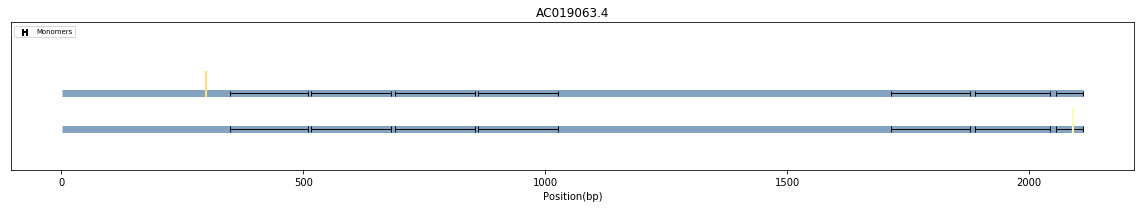

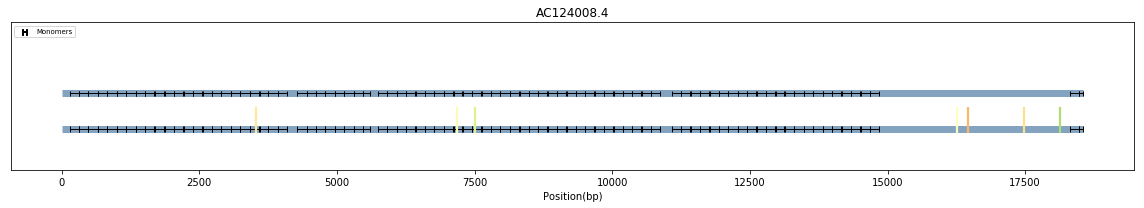

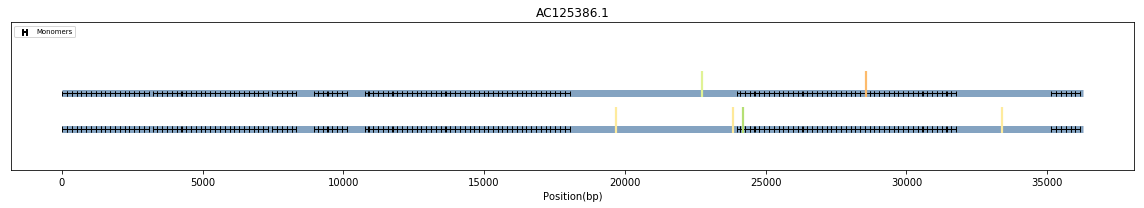

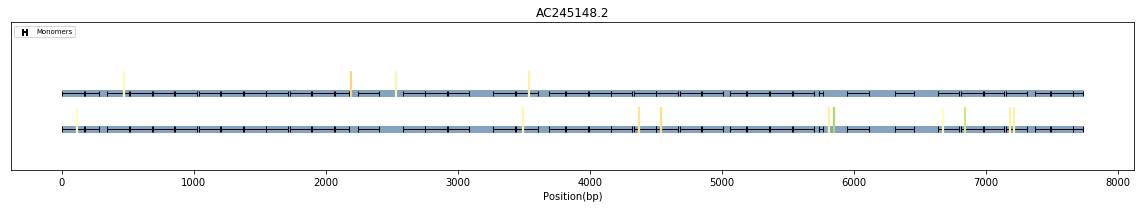

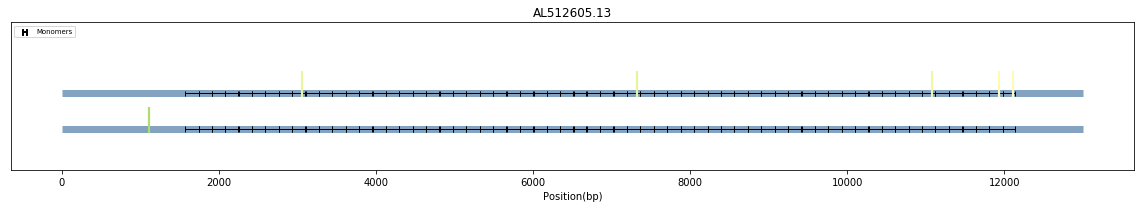

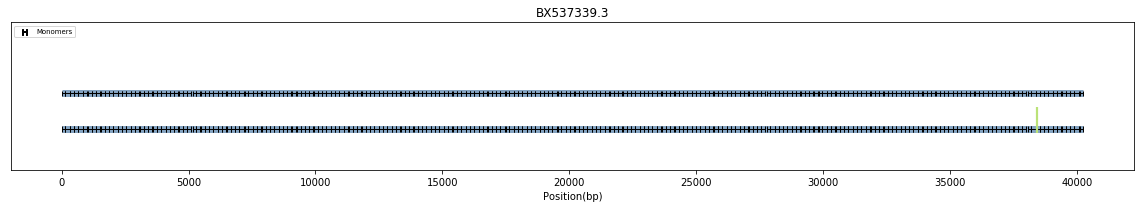

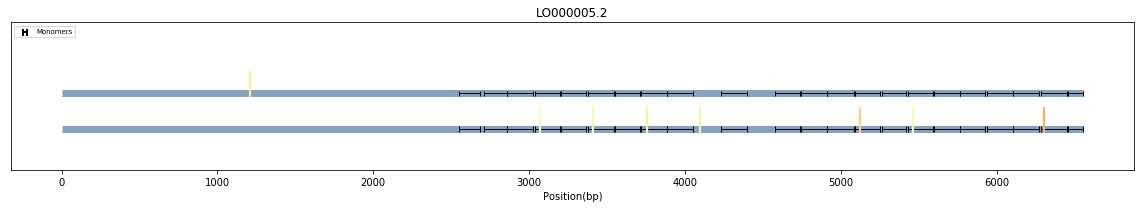

In [15]:
lista_clonas = []
for i,clona in enumerate(clonas):
    lista_clonas.append(tabla.loc[tabla.clone_id==clona])
clonas_perdidas = []
f = open('scores.csv','w')
for i in range(len(lista_clonas)):
    pos_leg = 'upper left'
    if lista_clonas[i].index[0] in df_output_motivos.index:
        f.write(lista_clonas[i].index[0]+',') 
        tamaño = int(df_output_motivos.loc[lista_clonas[i].index[0]]['tamaño'])
        zipped_limites = limites_monomeros(lista_clonas[i])
        zipped_pos_cajas = posicion_cajas(lista_clonas[i].index[0], df_output_motivos)
        graficar(tamaño,zipped_limites,zipped_pos_cajas,lista_clonas[i].index[0],i)
        f.write('\n')
    else:
        clonas_perdidas.append(lista_clonas[i].index[0])
f.close()
    
    